# **Linear regression model diagnosis**

Tests for the principal assumptions [1][5][6]:

1. Linearity: 
  * Pearson's Correlations for DV and each IV *
  * Harvey-Collier Multiplier test
  * Rainbow Test
  * Plot: Studentised Residuals vs Fitted Values
  * Plot: Partial Regression Plots *
  *	Mean of residuals is zero 

2. Independence: for time series data
  * Durbin Watson Test
  * Autocorrelation *

3. Homoscedasticity
  * F-test 
  * Breusch Pagan Test
  * Goldfeld Quandt Test
  * Plot: Studentised Residuals vs Fitted Values
                                    
4. Normality
  * Mean of Residuals (approx = 0)
  * Jarque-Bera test	
  * Shapiro-Wilk Test *	
  * Anderson-Darling test*
  * Kolmogorov-Smirnov test	*
  * Plot: Normal QQ Plot of Residuals

Addtional assumption tests:

5. No (perfect) Multicollinearity 
  * Pearson *
  * Pairwise Correlations between DVs *
  * Variance Inflation Factor


6. Outliers/Influence *
  * Standardised Residuals (> -3 & < +3)
  * Z-score
  * Cook's Distance
  * Plot: Boxplot of Standardised Residuals
  * Plot: Influence Plot with Cook's Distance

OLS assumptions[4]:

1. Errors are uncorrelated.

2. Errors have a mean of 0 

3. Errors have a constant variance.

\* to be added

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


current sklearn version: 0.22.2.post1 has no 'mean_absolute_precentage_error' metric

In [4]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [93]:
cols=['GAMMA','DTCO']
#X = data[cols]
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [94]:
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [105]:
X_train = X_train0[cols]
X_test = X_test0[cols]

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562, 2) (135562, 1)
(15063, 2) (15063, 1)


## Linear regression with statsmodels



In [106]:
model = sm.OLS(Y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DTSM   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                 4.459e+05
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:14:17   Log-Likelihood:            -5.3712e+05
No. Observations:              135562   AIC:                         1.074e+06
Df Residuals:                  135559   BIC:                         1.074e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.7333      0.165   -119.836      0.000     -20.056     -19.411
GAMMA         -0.0689      0.001    -76.414      0.000      -0.071      -0.067
DTCO           2.2092      0.003    843.855      0.000       2.204       2.214
==============================================================================
Omnibus:                     6027.266   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21080.990
Skew:                          -0.013   Prob(JB):                         0.00
Kurtosis:                       4.932   Cond. No.                         555.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##Multicollinearity





###Condition number test

Find the square root of the maximum eigenvalue divided by the minimum eigenvalue of the design matrix. Here statsmodels gives condition number with the unstatndardized variables. 

In [107]:
results.condition_number



554.9312687313192

###Variance inflation factors (VIF): 

a VIF of 5 or 10 and above indicates a multicollinearity problem.

In [108]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.values.shape[1])]
pd.DataFrame({'vif': vif[:]}, index=cols).T

,GAMMA,DTCO
vif,5.891872,5.891872


Another test (below) with more variable showing more serious multicollinearity. VIF imporoves whiile only GAMMA and DTCO are used as shown above.

|   | Depth | GAMMA | RHO | DTCO |
| --- | --- | --- | --- | --- |
| vif	| 6.700328 | 6.609758	| 28.853182	| 26.739058 |

In [110]:
#influence = OLSInfluence(results)


## Linearity


In [109]:
obser = Y_train.DTSM
pred = results.fittedvalues
resid = results.resid
resid_p = results.resid_pearson
resid_p2 = resid_p**2
dtco = X_train

coef = results.params.values[1:,]
part_resid = resid + coef @ X_train.values.T

mean_res = np.mean(resid)
stdv_res = np.std(resid)

print("Residual mean:", mean_res)
print("Residual stdv:", stdv_res)


Residual mean: 1.0828540885471013e-14
Residual stdv: 12.721007962183668


In [111]:
idx = np.random.choice(np.arange(len(pred)), 1000, replace=False)
resid_sample = resid.to_numpy()[idx]
pred_sample = pred.to_numpy()[idx]
obser_sample = obser.to_numpy()[idx]

pred_sort, resid_sort, obser_sort = zip(*sorted(zip(pred_sample, resid_sample, obser_sample)))
resid_sm = lowess(resid_sort,pred_sort)[:,1]
obser_sm = lowess(obser_sort,pred_sort)[:,1]

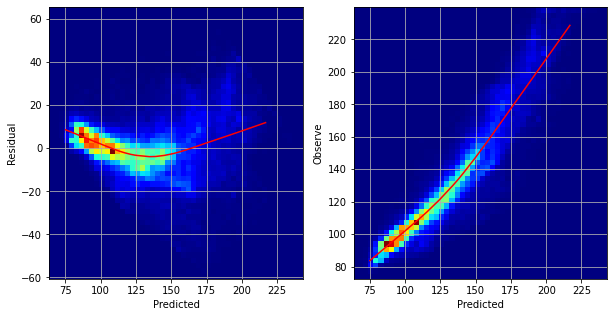

In [112]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.hist2d(pred, resid,bins=50, cmap='jet')
ax1.plot(pred_sort, resid_sm, color='red')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Residual")
ax1.grid()

ax2.hist2d(pred, obser,bins=50, cmap='jet')
ax2.plot(pred_sort, obser_sm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Observe")
ax2.grid()
plt.show()

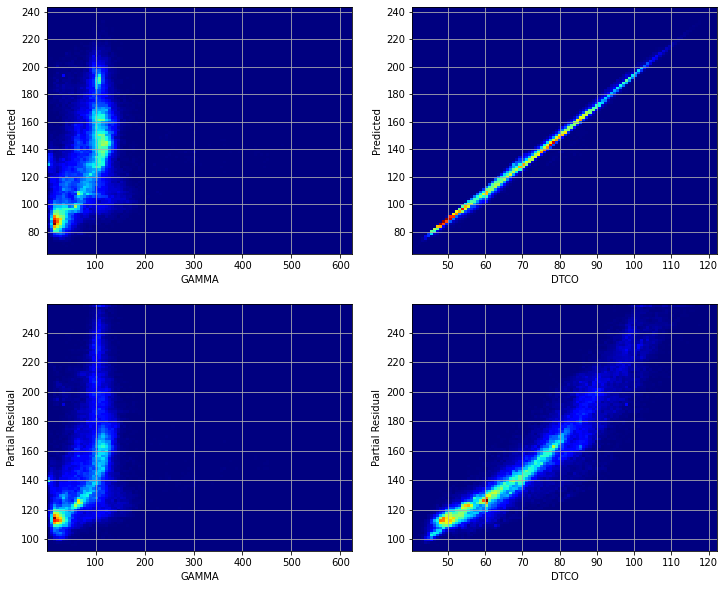

In [125]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, col in enumerate(cols):
  ax[0,i].hist2d(X_train[col], pred, bins=100, cmap='jet')
  #ax1.scatter(dtco, resid, s=1, color='blue')
  ax[0,i].set_xlabel(col)
  ax[0,i].set_ylabel("Predicted")
  ax[0,i].grid()

  ax[1,i].hist2d(X_train[col], part_resid,bins=100, cmap='jet')
  ax[1,i].set_xlabel(col)
  ax[1,i].set_ylabel("Partial Residual")
  ax[1,i].grid()
plt.show()

### Harvey-Collier multiplier test:
linear specification

In [114]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results)
lzip(name, test)

## current run outputs a "singular matrix" error due to probably linearly correlated variables.

[('t value', 0.27125705414792634), ('p value', 0.7861937474086325)]

Rainbow test

In [115]:
name = ['F statistic', 'p-value']
test = sms.linear_rainbow(results,frac=0.5)
lzip(name, test)

[('F statistic', 1.0072407175999825), ('p-value', 0.17382900938898524)]

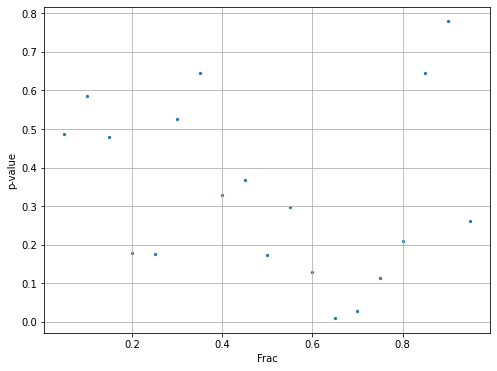

In [116]:
rain_frac=[]
rain_pv=[]
for frac in np.arange(0.05,1,0.05):
  (_,pv)=sms.linear_rainbow(results, frac=frac)
  rain_frac.append(frac)
  rain_pv.append(pv)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.scatter(rain_frac, rain_pv, s=5)
ax.set_xlabel('Frac')
ax.set_ylabel("p-value")
ax.grid()

The p-values of Harvey-Collier multiplier test suggest that the null hypothesis is not rejected here. 

The rainbow test gives linearity violation at some portion of the data. This suggests some nonlinearity.

Residual plot also shows a slight parabolic trend (red). 

A squared term of **dtco** will be added to the coming test models.

##Homoskedasticity tests

###White’s Two-Moment Specification Test: 
regression of the residual

In [117]:
name = ['statistic', 'p-value','dof']
test = sms.diagnostic.spec_white(resid, model.exog)
lzip(name, test)

[('statistic', 12638.986675732158), ('p-value', 0.0), ('dof', 5)]

###Breush-Pagan test

In [118]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 18998.745094989754),
 ('p-value', 0.0),
 ('f-value', 11047.438956772883),
 ('f p-value', 0.0)]

###Goldfeld-Quandt test

The standard deviation of the distribution is proportional to X.

In [119]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, model.exog)
lzip(name, test)

[('F statistic', 0.9976355338329224), ('p-value', 0.6210152545701102)]

Null hypothesis of white test and BP test are rejected and heteroskedasticity assumed. Null hypothesis of GQ test is not rejected. std is not proportional to variables.

OLS is unbiased and efficient. It remains unbiased under heteroskedasticity, but efficiency is lost. [4]

## Normality of the residuals



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


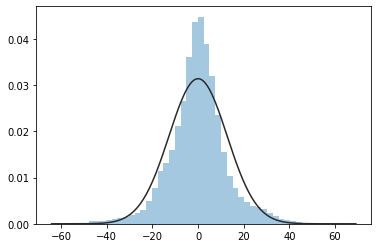

In [120]:
sns.distplot(resid, kde=False, fit=norm)

###Jarque-Bera test:

In [121]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)


[('Jarque-Bera', 21080.99013904287),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', -0.012980727824040363),
 ('Kurtosis', 4.931714418654094)]

Skewness is slightly positive, and a Kurtosis > 3 indicates higher probabilities at the mean and the tails than a normal distribution as the plot showing.

###Omni test:

In [122]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 6027.265665538136), ('Two-tail probability', 0.0)]

Both tests reject the null hypothesis that the residual data are normally distributed.

QQ-plot:


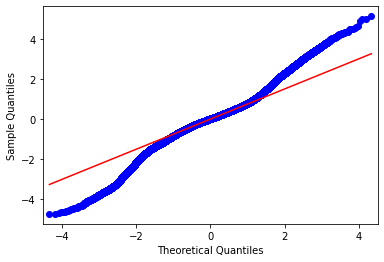

In [123]:
fig = sm.qqplot(results.resid, fit=True, line='q')

plt.show()

The data have more extrem values than expected as normal distriubted data. 

The following may be considered.

Use GLMs for non-Guassian errors

Nonlinearly transform target variables

remove potential outliers 

## Comments
Linearity is still hold under some tests. The plots however show a slight nonliear trend in the residuals. 

Homoscedasticity and normality are violated too.

A simple linear model is not a good model and the OLS is not blue in this case. A quadratic term of DTCO will be added to a polynomial regression model. 

## Reference
[1] 
https://people.duke.edu/~rnau/testing.htm

[2]
https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html

[3]
https://www.statsmodels.org/stable/diagnostic.html

[4]
https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

[5] https://github.com/rorytboyle/hierarchical_regression/blob/master/regression_diagnostics.py

[6] https://statisticsbyjim.com/regression/gauss-markov-theorem-ols-blue/


